Kaggle上一位博主分享了一份由明尼苏达大学GroupLens实验室和TMDB整理的一份电影数据，这包括电影的细节、票房情况、参演人员、电影评分等信息。博主希望通过对这些数据的深度分析，解决如下的几个问题：

- 1. 预测电影的票房/回报率
- 2. 哪些电影容易在TMBD上获得高的评分
- 3. 构建基于内容和基于用户的协同过滤推荐系统

### Importing Libraries and Loading Our Data

In [350]:
%matplotlib inline
from IPython.display import Image,HTML
import json
import datetime
import missingno as msno
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,XGBRegressor
from wordcloud import WordCloud,STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
plt.style.use('classic')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth',50)

In [2]:
df = pd.read_csv('the-movies-dataset/movies_metadata.csv')
display(df.head(2).transpose())

,0,1
adult,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN
budget,30000000,65000000
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
homepage,http://toystory.disney.com/toy-story,NaN
id,862,8844
imdb_id,tt0114709,tt0113497
original_language,en,en
original_title,Toy Story,Jumanji
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...


## Understanding the Dataset

In [3]:
display(df.shape)

(45466, 24)

In [4]:
display(df.columns.tolist())

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

### Features

- adult: 是否为青少年禁看的X级片.
- belongs_to_collection: 字符串化存储的电影系列信息.
- budget: 电影预算.
- genres: 字符串化存储中电影流派的信息.
- homepage: 电影的官方主页.
- id: 电影ID.
- imdb_id: 电影在IMDB上的ID.
- original_language: 电影母语.
- original_title: 电影原始的标题.
- overview: 电影简介.
- popularity: 电影在IMDB上的人气评分.
- poster_path: 电影海报的URL链接地址.
- production_companies: 制片公司的相关信息，字符串化存储.
- production_countries: 电影拍摄地所属国家的信息，字符串化存储.
- release_date: 电影上映日期.
- revenue: 电影的票房总收入.
- runtime: 电影播放时长.
- spoken_languages: 在电影中说的口语，字符串化存储.
- status: 电影的状态(Released已发布, To Be Released待发布,Announced预告, etc.)
- tagline: 电影口碑.
- title: 电影的官方标题.
- video: 是否在TMDB上有video版本的电影.
- vote_average: 电影的平均评分.
- vote_count: 电影的评分次数.

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

None

数据集包含45466条电影的信息，每条信息由24个特征组成。数据仅仅存在非常少量的缺失（homepage和tagline）。

## Data Wrangling

In [6]:
df = df.drop(['imdb_id'],axis=1)

首先我们好奇的是，每条电影信息都包含`title`和`original_title`，这两个到底有什么区别呢？

In [7]:
df[df['original_title'] != df['title']][['title','original_title']].head(20)

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal
67,French Twist,Gazon maudit
72,Les Miserables,Les misérables
79,The White Balloon,بادکنک سفید
81,Antonia's Line,Antonia
104,Nobody Loves Me,Keiner liebt mich


从上面的结果来看，`original_title`是制片方国家的语言或者是缩写，或者是简短描述，总体来看，`title`的表述格式更加统一，内容也更为丰富，使用`title`作为分析目标会比使用`original_title`要方便的多，因此这里我们将`original_title`删去。

In [8]:
df = df.drop(['original_title'],axis=1)

### 查看数据缺失情况

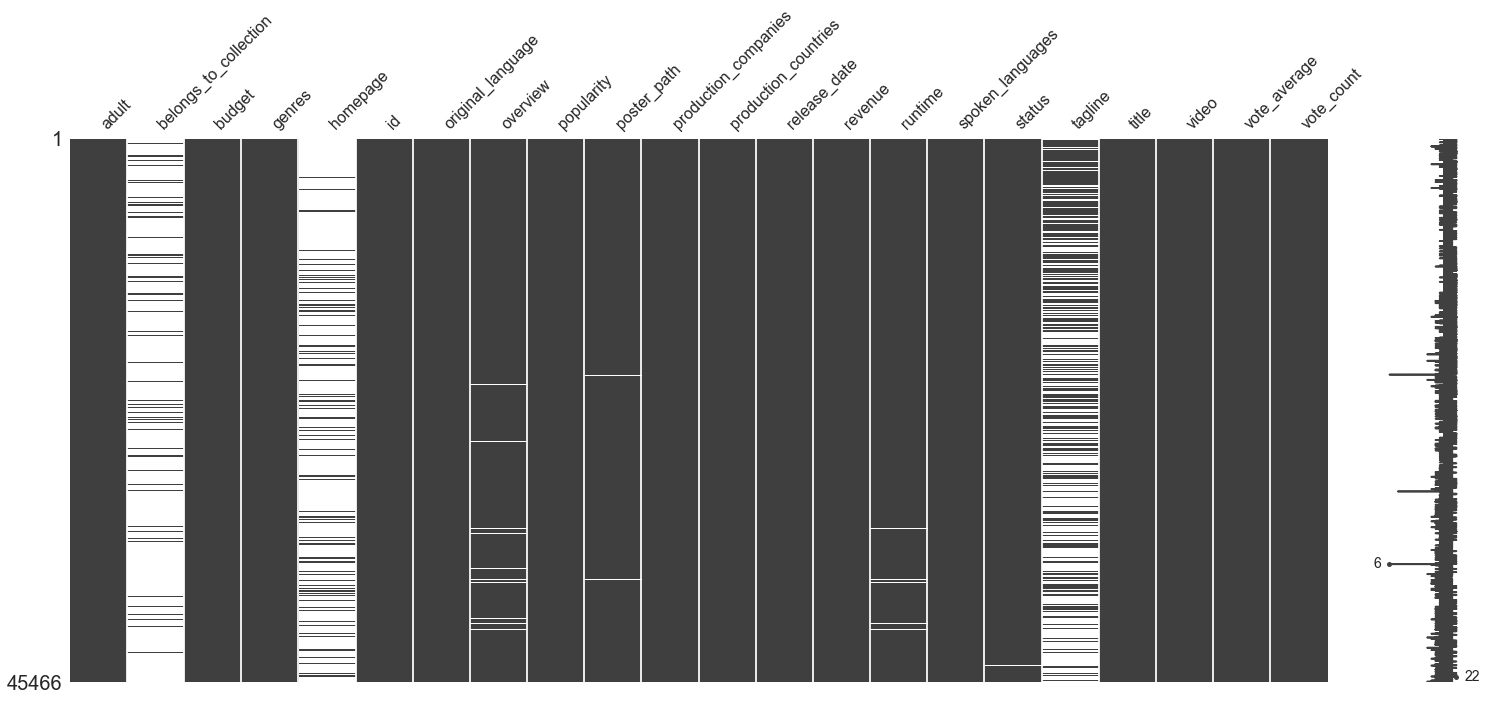

In [9]:
msno.matrix(df=df)

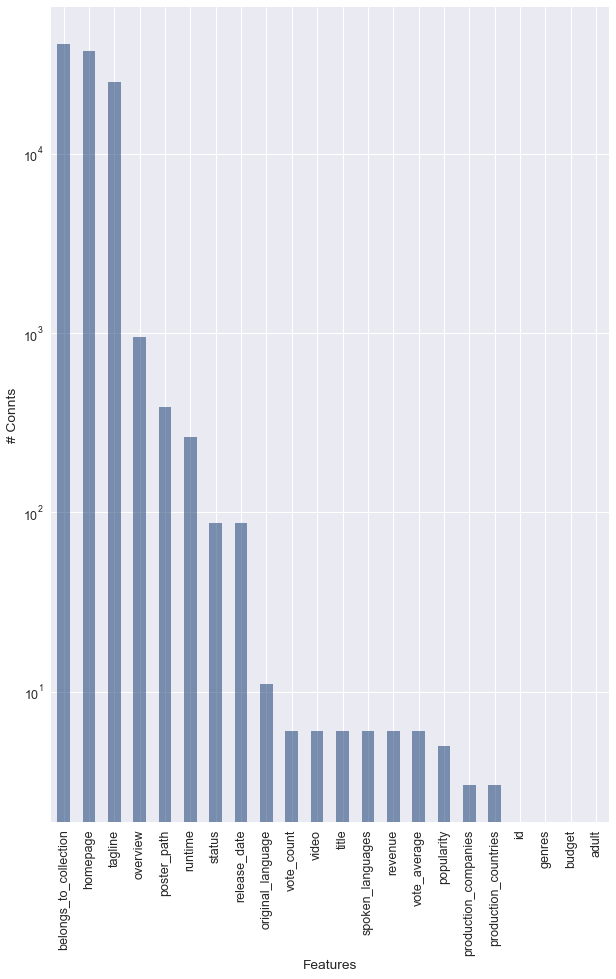

In [10]:
MissingCounts = df.isna().sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(10,15))
MissingCounts.plot(kind='bar',colormap=plt.cm.Blues_r,logy=True,alpha=0.5)
plt.ylabel('# Connts')
plt.xlabel('Features')
plt.show()

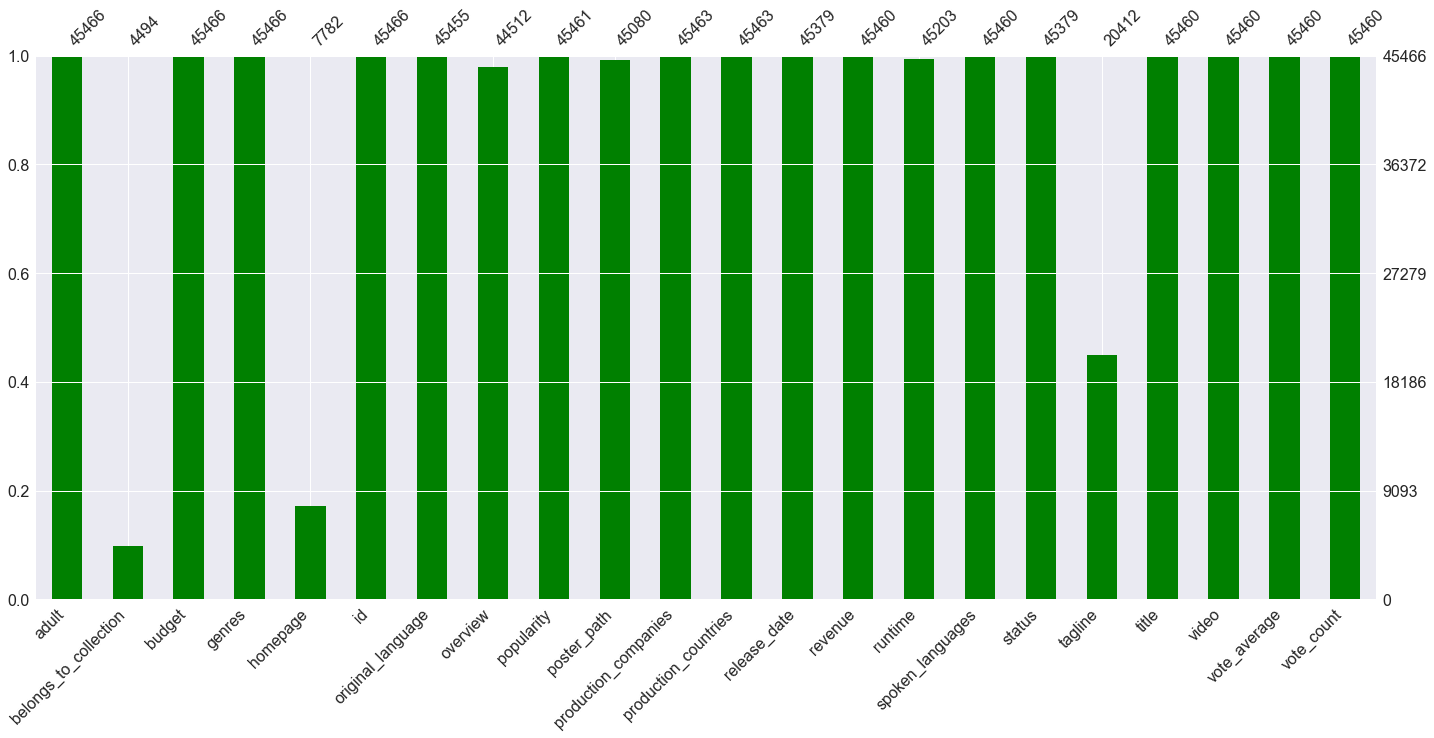

In [11]:
msno.bar(df=df,color='g')

从上图特征缺失柱状图来看，`belongs_to_collection`,`homepage`,`tagline`存在较严重的数据缺失情况(>10000)。`overview`,`poster_path`,`runtime`,`status`存在少量缺失(<1000)，还有其他几个特征存在极个别的缺失。

<Figure size 432x288 with 0 Axes>

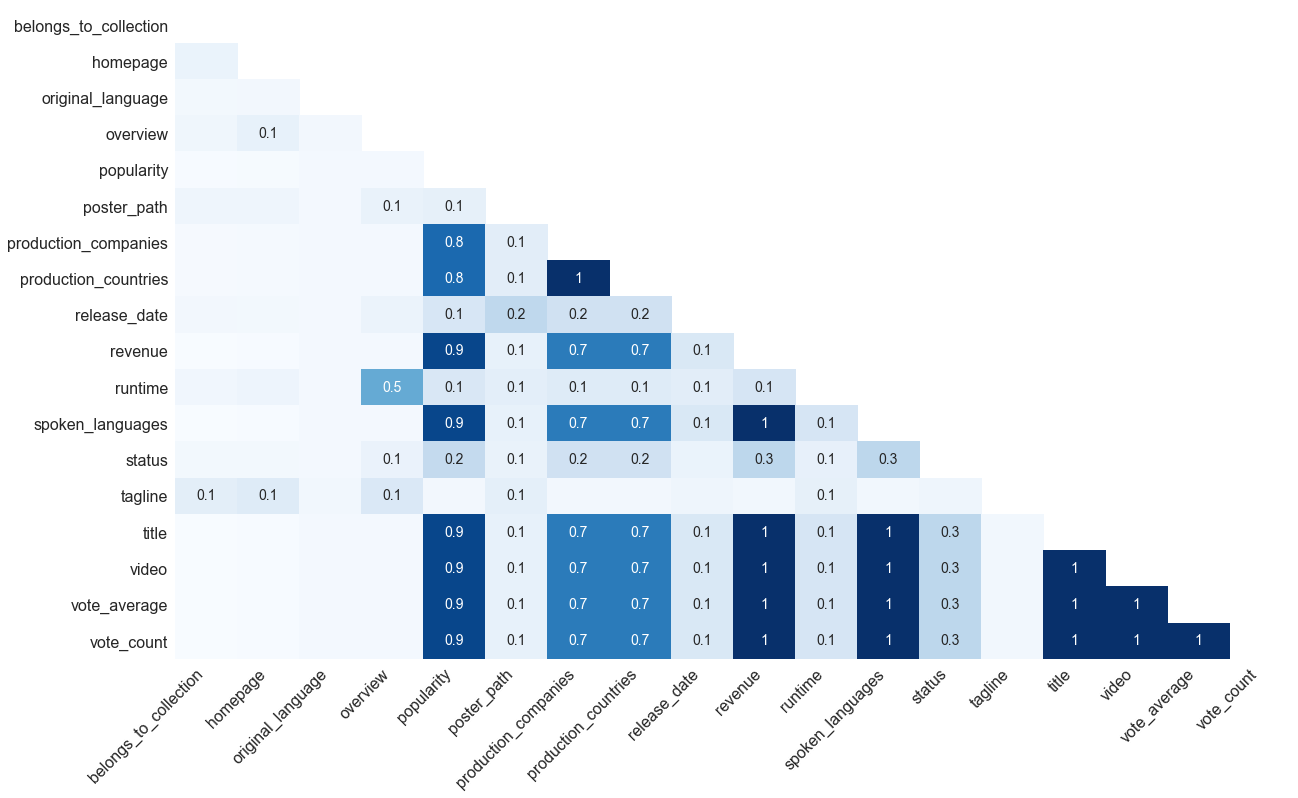

In [12]:
plt.figure()
msno.heatmap(df,cmap=plt.cm.Blues,inline=True)
plt.show()

从数据缺失情况的伴随来看，缺失最严重的三个特征，不存在伴随的情况，缺失数量较少的几个特征，如`popularity`,`revenue`,`production_countries`等存在较严重的伴随。

### 目标特征 - revenue（票房收入）

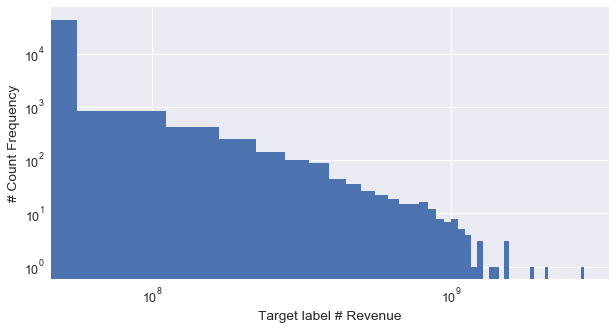

In [13]:
plt.figure()
df['revenue'].plot(kind='hist',bins=50,logy=True,logx=True,figsize=(10,5))
plt.xlabel('Target label # Revenue')
plt.ylabel('# Count Frequency')
plt.show()

In [14]:
print('{} revenue value is NaN.'.format(df['revenue'].isna().sum()))
print('{} revenue value is equal to 0.'.format((df['revenue']==0).sum()))

6 revenue value is NaN.
38052 revenue value is equal to 0.


我们发现，`revenue`中大量存在值为0的情况，这不符合常识，电影票房不可能为0，应该是缺失了这部分的数据。

In [15]:
df['revenue'] = df['revenue'].replace(0,np.nan)

### 关键特征 - budget

`budget`特征中有一些格式不太正常的数据，使得Pandas将这些数据识别为类别目标，这里我们需要先将这样的情况处理掉，强制将所有这样情况转变为数值型，并将`budget`中为0的值替换为NaN。

In [16]:
df['budget'] = pd.to_numeric(df['budget'],errors='coerce')
df['budget'] = df['budget'].replace(0,np.nan)
print(df[df['budget'].isna()].shape)

(36576, 22)


### 关键特征

- **year**：电影上映时间
- **return**：票房收入相对于预算的回报率

回报率能够比较直观的体现一部电影在商业经济方面成功，回报率大于1的代表收益，小于1代表亏损。

In [17]:
df['return'] = df['revenue']/df['budget']
df[df['return'].isnull()].shape

(40085, 23)

我们仅有10%的数据能够计算出`return`的值，虽然似乎有点小，但也足够展示全世界这些电影普遍存在的一些有趣的特征。

In [18]:
df['year'] = pd.to_datetime(df['release_date'],errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [19]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 - Written by Ørnås                                                                                                                   1
Name: adult, dtype: int64

`adult`特征仅有9个位True，还有几个不能理解的错误，整体来看，`adult`特征对于分析和预测没有多少价值。

In [20]:
df = df.drop(['adult'],axis=1)

In [325]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
df['poster_path'] = "<img src='" + base_poster_url + df['poster_path'] + "' style='height:100px;'>"

### 数据分析探索

#### Title和Overview词云分析WordCloud

In [22]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [23]:
title_corpus = ' '.join(df['title'].tolist())
overview_corpus = ' '.join(df['overview'].tolist())

In [24]:
title_wordcloud = WordCloud(stopwords=STOPWORDS,
                            background_color='white',
                            height=2000,
                            width=4000).generate(title_corpus)

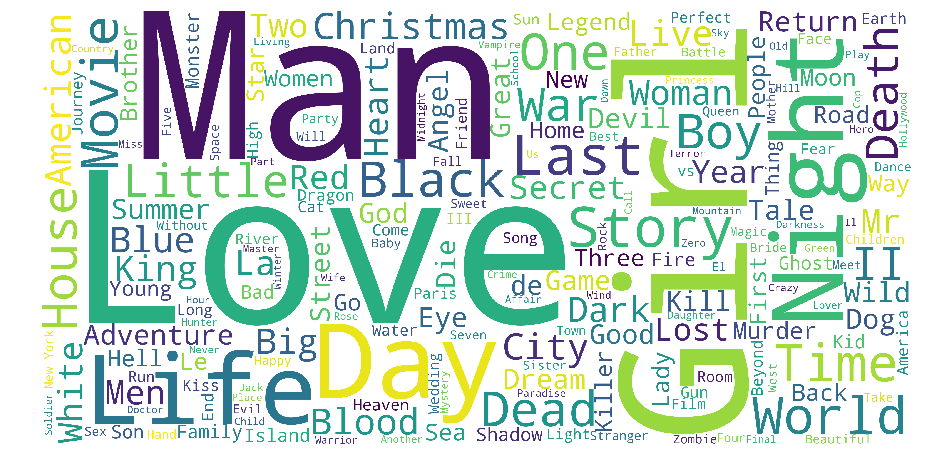

In [25]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

**Love**是`Title`中使用频次最高的词汇，同样的还有**Man,Girl,Day**这类词。

In [26]:
overview_wordcorpus = WordCloud(stopwords=STOPWORDS,
                                background_color='white',
                                height=2000,
                                width=4000).generate(overview_corpus)

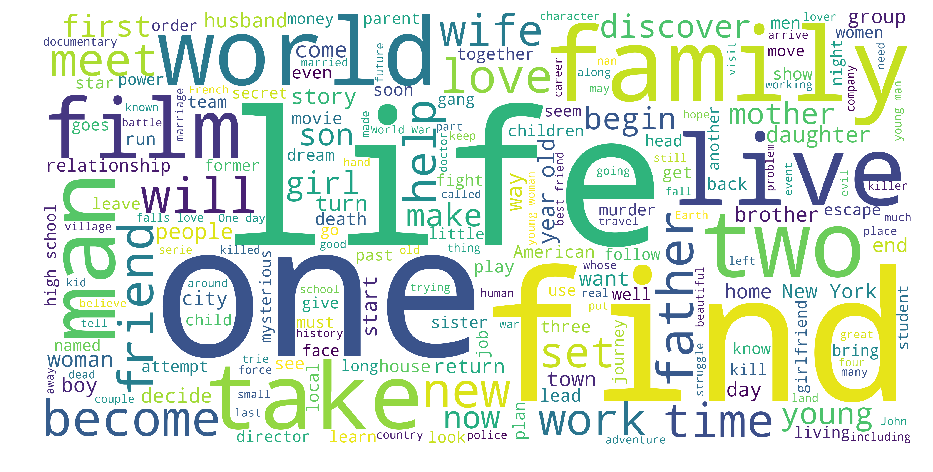

In [27]:
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcorpus)
plt.axis('off')
plt.show()

**Life,Find,One**是在`overview`中最常用的词汇，还有**live,family,world**这类能够体现一部分的主题。

#### Production Countries

In [28]:
display(df['production_countries'].sample(10))

29357              [{'iso_3166_1': 'IT', 'name': 'Italy'}]
38779                                                   []
20555    [{'iso_3166_1': 'US', 'name': 'United States o...
33616                                                   []
45059            [{'iso_3166_1': 'DK', 'name': 'Denmark'}]
36966             [{'iso_3166_1': 'CA', 'name': 'Canada'}]
45449    [{'iso_3166_1': 'US', 'name': 'United States o...
18050              [{'iso_3166_1': 'IT', 'name': 'Italy'}]
9164     [{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...
18042    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

In [29]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x,list) else [])

In [30]:
print(df['production_countries'].sample(20))

595                                                     []
22042                                     [United Kingdom]
9550     [United Kingdom, Italy, Luxembourg, United Sta...
16690                                                   []
23010                                             [Brazil]
41521                                              [India]
22150                           [Denmark, Finland, Sweden]
11409                           [United States of America]
6244                            [United States of America]
27485                                     [United Kingdom]
21523                                                   []
23217                                              [Japan]
26771         [Canada, France, Luxembourg, United Kingdom]
28427                           [United States of America]
29624                                                   []
28873                                                   []
11108                           [United States of Americ

In [31]:
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1,drop=True)
s.name = 'countries'

In [32]:
s

0        United States of America
1        United States of America
2        United States of America
3        United States of America
4        United States of America
5        United States of America
6                         Germany
6        United States of America
7        United States of America
8        United States of America
9                  United Kingdom
9        United States of America
10       United States of America
11                         France
11       United States of America
12       United States of America
13       United States of America
14                         France
14                        Germany
14                          Italy
14       United States of America
15                         France
15       United States of America
16                 United Kingdom
16       United States of America
17       United States of America
18       United States of America
19       United States of America
20       United States of America
21       Unite

In [33]:
con_df = df.drop('production_countries',axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies','country']
con_df = con_df.reset_index(drop=True)

In [34]:
con_df.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


In [35]:
con_df = con_df[con_df['country'] != 'United States of America']

In [36]:
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies (Apart from US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

#### Franchise Movies

In [37]:
display(df['belongs_to_collection'].sample(10))

9167                                                   NaN
21523                                                  NaN
24828    {'id': 350836, 'name': 'Dark Planet Collection...
33652                                                  NaN
16880                                                  NaN
39800                                                  NaN
8510                                                   NaN
14202                                                  NaN
23767    {'id': 126125, 'name': 'The Expendables Collec...
15304                                                  NaN
Name: belongs_to_collection, dtype: object

In [38]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

In [39]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection',values='revenue',aggfunc={'revenue':['mean','sum','count']}).reset_index()

In [40]:
fran_pivot.sort_values('sum',ascending=False).head(10)

,belongs_to_collection,count,mean,sum
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
646,James Bond Collection,26,2.733450e+08,7.106970e+09
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
1550,Transformers Collection,5,8.732202e+08,4.366101e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
1491,The Twilight Collection,5,6.684215e+08,3.342107e+09
610,Ice Age Collection,5,6.433417e+08,3.216709e+09
666,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


**Harry Potter**是目前商业上最成功的电影，8部系列电影收获了超过77亿美元的票房收入。**Star Wars**紧随其后，8部系列电影收获了超过74亿美元的票房收入。**James Bond**系列26电影总共收获了71亿美元的票房收入，排在第三，但每部电影的平均收入较低于前两部。

#### Most Successful Movie Franchises (by Average Gross)

In [42]:
fran_pivot.sort_values(by='mean',ascending=False).head(10)

,belongs_to_collection,count,mean,sum
112,Avatar Collection,1,2.787965e+09,2.787965e+09
1245,The Avengers Collection,2,1.462481e+09,2.924962e+09
479,Frozen Collection,1,1.274219e+09,1.274219e+09
446,Finding Nemo Collection,2,9.844532e+08,1.968906e+09
1352,The Hobbit Collection,3,9.785078e+08,2.935523e+09
1388,The Lord of the Rings Collection,3,9.721816e+08,2.916545e+09
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
325,Despicable Me Collection,4,9.227676e+08,3.691070e+09
968,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09


从系列电影的平均票房收入来评价电影的成功，**Avatar**是历史上最成功的电影，单部电影票房收入达到27.8亿美元。榜上还有其他的一些我们耳熟能详的电影，包括**The Avengers, Frozen, Finding Nemo**等等，**Harry Potter**也在榜单上，因此可见观众对这部电影的喜爱程度。

#### Longest Running Franchises

In [43]:
fran_pivot.sort_values('count',ascending=False).head(10)

,belongs_to_collection,count,mean,sum
646,James Bond Collection,26,2.733450e+08,7.106970e+09
473,Friday the 13th Collection,12,3.874155e+07,4.648985e+08
976,Pokémon Collection,11,6.348189e+07,6.983008e+08
552,Harry Potter Collection,8,9.634209e+08,7.707367e+09
540,Halloween Collection,8,3.089601e+07,2.471681e+08
29,A Nightmare on Elm Street Collection,8,4.544894e+07,3.635916e+08
1317,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
1432,The Pink Panther (Original) Collection,8,2.055978e+07,1.644782e+08
1160,Star Wars Collection,8,9.293118e+08,7.434495e+09
977,Police Academy Collection,7,4.352046e+07,3.046432e+08


#### Production Companies

In [44]:
display(df['production_companies'].head())

0       [{'name': 'Pixar Animation Studios', 'id': 3}]
1    [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2    [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3    [{'name': 'Twentieth Century Fox Film Corporat...
4    [{'name': 'Sandollar Productions', 'id': 5842}...
Name: production_companies, dtype: object

In [45]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x,list) else [])

In [52]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1,drop=True)
s.head(10)

0                   Pixar Animation Studios
1                          TriStar Pictures
1                              Teitler Film
1                 Interscope Communications
2                              Warner Bros.
2                            Lancaster Gate
3    Twentieth Century Fox Film Corporation
4                     Sandollar Productions
4                       Touchstone Pictures
5                       Regency Enterprises
dtype: object

In [53]:
s.name = 'companies'

In [54]:
com_df = df.drop(['production_companies'],axis=1).join(s)

In [65]:
com_pivot = com_df.groupby('companies')['revenue'].agg(['sum','mean','count'])
com_pivot.columns = ['Total','Average','Number']
com_pivot.head()

,Total,Average,Number
companies,,,
"""DIA"" Productions GmbH & Co. KG",44350926.0,44350926.0,1
# Andrea Sperling Productions,0.0,NaN,0
# Lexyn Productions,0.0,NaN,0
'A' Production Committee,0.0,NaN,0
(주)로드픽쳐스,0.0,NaN,0


### Hightest Earning Production Companies

In [66]:
com_pivot.sort_values(by='Total',ascending=False).head(10)

,Total,Average,Number
companies,,,
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Walt Disney Pictures,4.083727e+10,2.778046e+08,147
Columbia Pictures,3.227974e+10,1.367785e+08,236
New Line Cinema,2.217339e+10,1.119868e+08,198
Amblin Entertainment,1.734372e+10,2.550547e+08,68
DreamWorks SKG,1.547575e+10,1.984071e+08,78


### Most Succesful Production Companies

In [67]:
com_pivot[com_pivot['Number']>=15].sort_values(by='Average',ascending=False).head(10)

,Total,Average,Number
companies,,,
Pixar Animation Studios,1.118853e+10,6.215852e+08,18
Marvel Studios,1.169964e+10,6.157703e+08,19
Revolution Sun Studios,8.120339e+09,5.413559e+08,15
Lucasfilm,9.898421e+09,4.499282e+08,22
DreamWorks Animation,1.370752e+10,4.031622e+08,34
DC Entertainment,6.212609e+09,3.882880e+08,16
Dentsu,6.853205e+09,3.807336e+08,18
Jerry Bruckheimer Films,8.957441e+09,3.732267e+08,24
Marvel Enterprises,6.538067e+09,3.441088e+08,19


### The Highest Producting Companies

In [68]:
com_pivot.sort_values(by='Number',ascending=False).head(10)

,Total,Average,Number
companies,,,
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Columbia Pictures,3.227974e+10,1.367785e+08,236
Metro-Goldwyn-Mayer (MGM),1.237679e+10,5.979126e+07,207
New Line Cinema,2.217339e+10,1.119868e+08,198
Touchstone Pictures,1.412178e+10,8.937839e+07,158
Walt Disney Pictures,4.083727e+10,2.778046e+08,147


### Original Language

In [69]:
df['original_language'].unique().shape

(93,)

In [70]:
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number','language']
lang_df.head(10)

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de
es,994,es
ru,826,ru
hi,508,hi
ko,444,ko
zh,409,zh


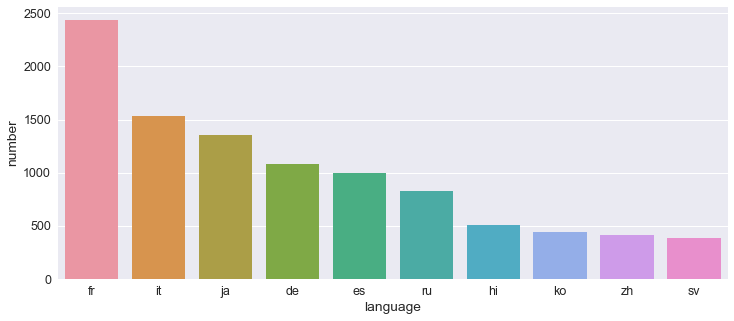

In [75]:
plt.figure(figsize=(12,5))
sns.barplot(data=lang_df.iloc[1:11],x='language',y='number')

plt.show()

#### Popularity, Vote Average and Vote Count

In [76]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [77]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [79]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

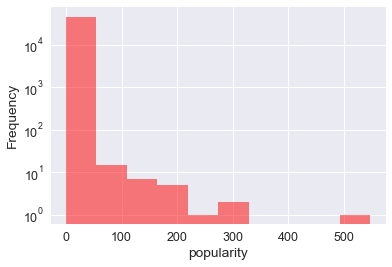

In [85]:
plt.figure()
df['popularity'].plot(kind='hist',logy=True,color='r',alpha=0.5)
plt.xlabel('popularity')
plt.show()

In [86]:
df[['title','popularity','year']].sort_values(by='popularity',ascending=False).head(10)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


In [87]:
df['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [88]:
df[['title','vote_count','year']].sort_values(by='vote_count',ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


In [89]:
df['vote_average'] = df['vote_average'].replace(0,np.nan)
df['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

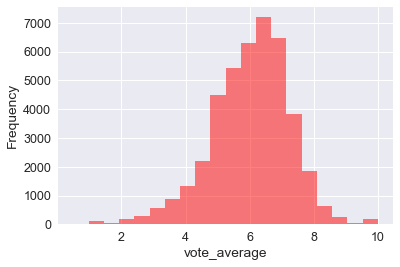

In [96]:
plt.figure()
df['vote_average'].plot(kind='hist',bins=20,alpha=0.5,color='r')
plt.xlabel('vote_average')
plt.show()

### Most Critically Acclaimed Movies

In [97]:
df[df['vote_count']>2000][['title','vote_average','vote_count','year']].sort_values('vote_average',ascending=False).head(10)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
1176,Psycho,8.3,2405.0,1960
2843,Fight Club,8.3,9678.0,1999
1178,The Godfather: Part II,8.3,3418.0,1974
12481,The Dark Knight,8.3,12269.0,2008
292,Pulp Fiction,8.3,8670.0,1994


<Figure size 432x288 with 0 Axes>

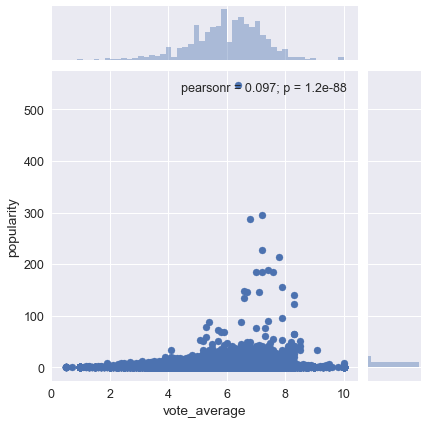

In [100]:
plt.figure()
sns.jointplot(data=df,x='vote_average',y='popularity')
plt.show()

<Figure size 432x288 with 0 Axes>

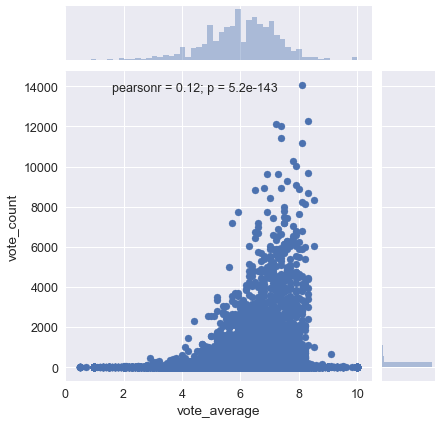

In [102]:
plt.figure()
sns.jointplot(x='vote_average',y='vote_count',data=df)
plt.show()

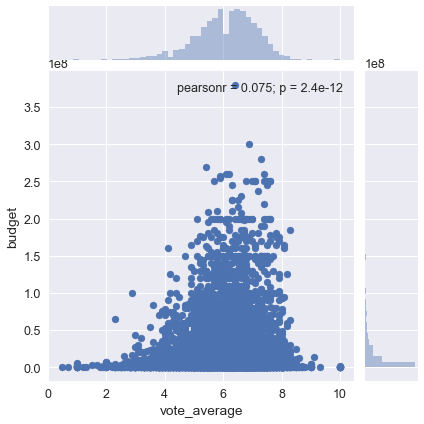

In [106]:
sns.jointplot(data=df,y='budget',x='vote_average',dropna=True)

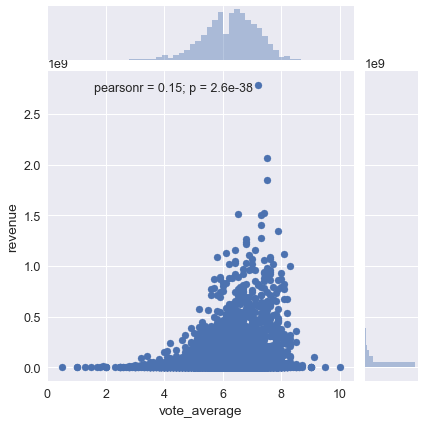

In [107]:
sns.jointplot(data=df,x='vote_average',y='revenue')

### Movie Release Dates

In [211]:
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
day_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

In [212]:
df['release_date'] = pd.to_datetime(df['release_date'],errors='coerce')

In [213]:
df['release_date'].isnull().sum()

90

In [220]:
def get_month(x):
    try:
        month = x.month
        return month_order[month-1]
    except:
        return np.nan

In [230]:
def get_day(x):
    try:
        weekday = x.weekday()
        return day_order[weekday]
    except:
        return np.nan

In [231]:
df['release_date'][0]

Timestamp('1995-10-30 00:00:00')

In [232]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

In [233]:
df[['day','month','title']].head()

,day,month,title
0,Mon,Oct,Toy Story
1,Fri,Dec,Jumanji
2,Fri,Dec,Grumpier Old Men
3,Fri,Dec,Waiting to Exhale
4,Fri,Feb,Father of the Bride Part II


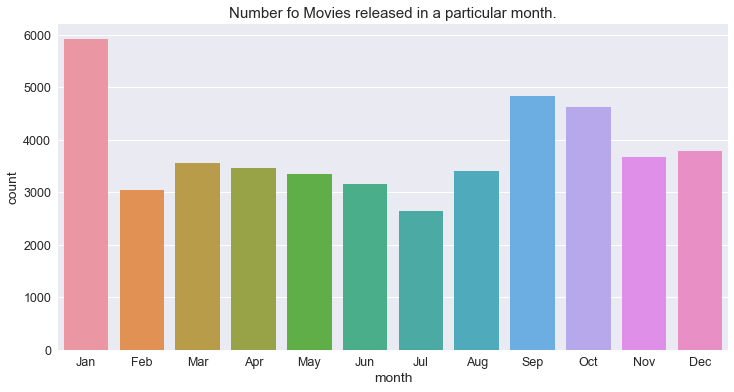

In [234]:
plt.figure(figsize=(12,6))
plt.title('Number fo Movies released in a particular month.')
sns.countplot(data=df,x='month',order=month_order)
plt.show()

In [235]:
month_mean = pd.DataFrame(df[df['revenue']>1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index

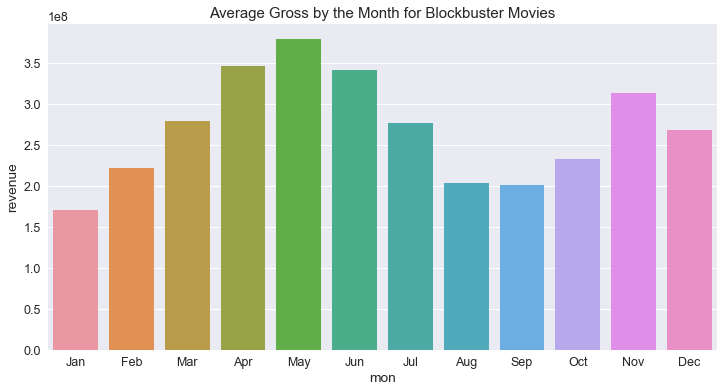

In [236]:
plt.figure(figsize=(12,6))
plt.title('Average Gross by the Month for Blockbuster Movies')
sns.barplot(data=month_mean,x='mon',y='revenue',order=month_order)
plt.show()

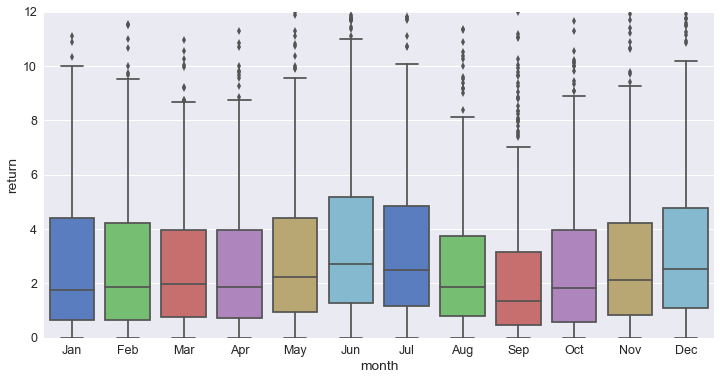

In [237]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['return'].notnull()],x='month',y='return',palette='muted',order=month_order)
plt.ylim([0,12])
plt.show()

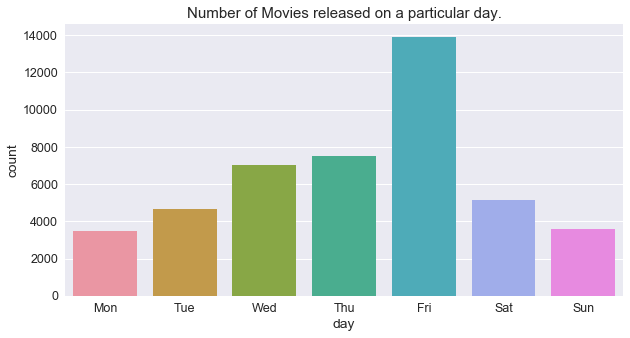

In [238]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies released on a particular day.")
sns.countplot(x='day', data=df, order=day_order)

### Number of Movies by the year

In [271]:
year_count = df.pivot_table(index='year',values='title',aggfunc='count')
year_count['year'] = year_count.index
year_count.columns = ['Count','year']
year_count = year_count.reset_index(drop=True)

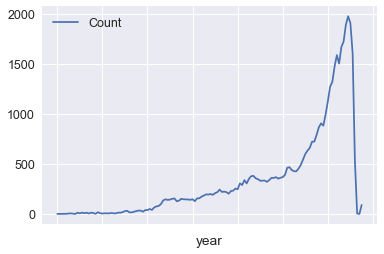

In [272]:
year_count.plot(x='year',y='Count')

### Earliest Movies Represennted

In [274]:
df[df['year'].notnull()][['title','year']].sort_values(by='year').head(10)

,title,year
34940,Passage of Venus,1874
34937,Sallie Gardner at a Gallop,1878
41602,Buffalo Running,1883
34933,Man Walking Around a Corner,1887
34938,Traffic Crossing Leeds Bridge,1888
34934,Accordion Player,1888
34936,"Monkeyshines, No. 2",1890
39954,"Monkeyshines, No. 3",1890
34935,"Monkeyshines, No. 1",1890
34939,London's Trafalgar Square,1890


In [275]:
months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
          'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [277]:
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year']>2000]
hmap_21 = pd.pivot_table(data=df_21,index='month',columns='year',values='title',aggfunc='count')
hmap_21 = hmap_21.fillna(0)

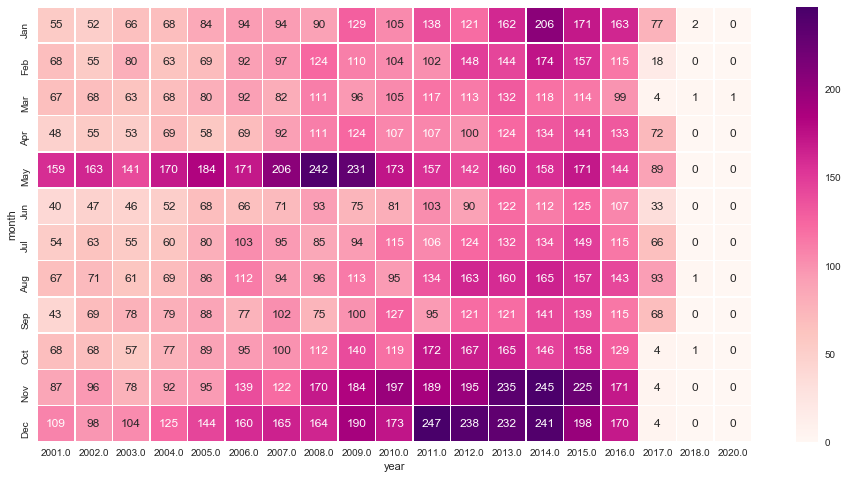

In [288]:
sns.set(font_scale=1)
plt.figure(figsize=(16,8))
sns.heatmap(hmap_21,annot=True,linewidths=0.5,fmt='n',yticklabels=month_order,cmap=plt.cm.RdPu)
plt.show()

#### Movie Status

In [289]:
df['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

### Spoken Language

In [291]:
print(df['spoken_languages'].sample(10))

35238                 [{'iso_639_1': 'ja', 'name': '日本語'}]
6678              [{'iso_639_1': 'en', 'name': 'English'}]
7281              [{'iso_639_1': 'en', 'name': 'English'}]
30548              [{'iso_639_1': 'pl', 'name': 'Polski'}]
2058     [{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...
9437     [{'iso_639_1': 'ko', 'name': '한국어/조선말'}, {'iso...
35479                                                   []
21118             [{'iso_639_1': 'en', 'name': 'English'}]
31769                                                   []
11631             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object


In [292]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [294]:
df['spoken_languages'].value_counts().sort_index()

0      3835
1     33736
2      5371
3      1705
4       550
5       178
6        62
7        14
8         6
9         5
10        1
12        1
13        1
19        1
Name: spoken_languages, dtype: int64

In [297]:
df[df['spoken_languages']>=10][['title','year','spoken_languages']].sort_values('spoken_languages',ascending=False)

,title,year,spoken_languages
22235,Visions of Europe,2004,19
35288,The Testaments,2000,13
14093,To Each His Own Cinema,2007,12
8789,The Adventures of Picasso,1978,10


### Runtime

In [298]:
df['runtime'].describe()

count    45203.000000
mean        94.128199
std         38.407810
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

In [299]:
df['runtime'] = df['runtime'].astype('float')

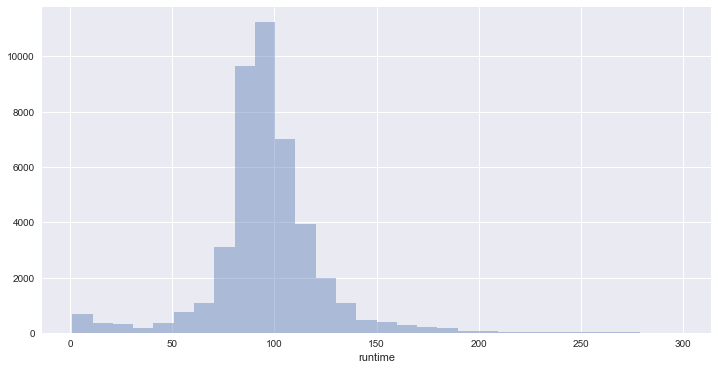

In [301]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime']<300)&(df['runtime']>0)]['runtime'],bins=30,kde=False)
plt.show()

In [302]:
df_mat = df[(df['return'].notnull())&(df['runtime']>0)&(df['return']<10)]

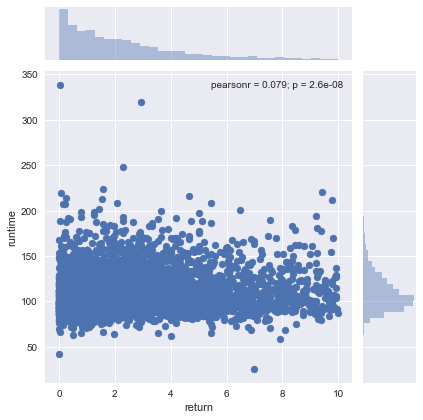

In [303]:
sns.jointplot(data=df_mat,x='return',y='runtime')
plt.show()

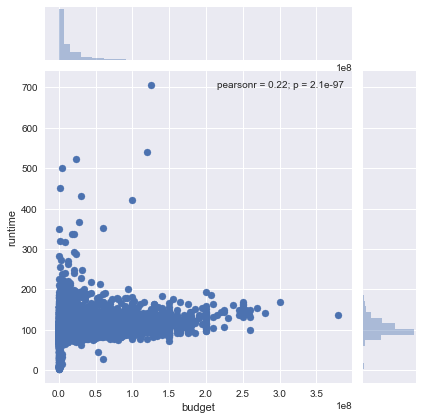

In [304]:
df_mat = df[(df['budget'].notnull())&(df['runtime']>0)]
sns.jointplot(data=df_mat,x='budget',y='runtime')
plt.show()

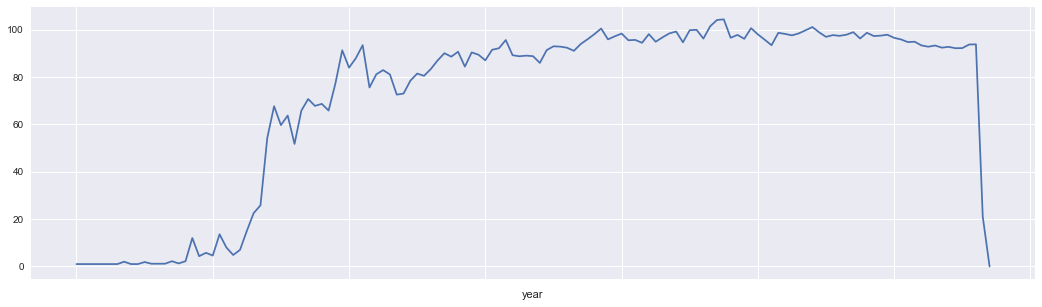

In [311]:
plt.figure(figsize=(18,5))
year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()
year_runtime.plot()
plt.show()

### Shortest Movies

In [312]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10)

,runtime,title,year
35146,1.0,La Vague,1891
36577,1.0,Champs de Mars,1900
36576,1.0,Palace of Electricity,1900
44965,1.0,"Luis Martinetti, Contortionist",1894
42357,1.0,A Gathering of Cats,2007
36575,1.0,Eiffel Tower from Trocadero Palace,1900
36574,1.0,Panorama of Eiffel Tower,1900
44714,1.0,The Infernal Caldron,1903
19244,1.0,The Kiss,1896
44646,1.0,The Vanishing Lady,1896


#### Longest Movies

In [313]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False).head(10)

,runtime,title,year
24178,1256.0,Centennial,1978
40938,1140.0,Baseball,1994
19965,1140.0,Jazz,2001
13767,931.0,Berlin Alexanderplatz,1980
13953,925.0,Heimat: A Chronicle of Germany,1984
27855,900.0,The Story of Film: An Odyssey,2011
26682,877.0,Taken,2002
19158,874.0,The War,2007
34667,840.0,The Roosevelts: An Intimate History,2014
34732,840.0,Seventeen Moments in Spring,1973


In [314]:
df['budget'].describe()

count    8.890000e+03
mean     2.160428e+07
std      3.431063e+07
min      1.000000e+00
25%      2.000000e+06
50%      8.000000e+06
75%      2.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

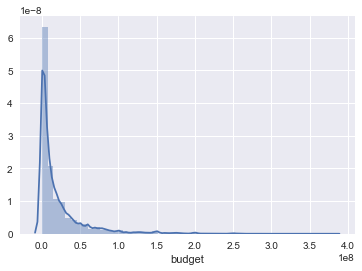

In [315]:
sns.distplot(df[df['budget'].notnull()]['budget'])

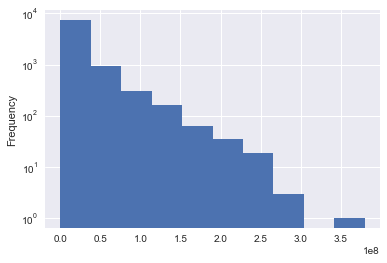

In [316]:
df['budget'].plot(logy=True, kind='hist')

In [317]:
df[df['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(10)

,title,budget,revenue,return,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
11827,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
26558,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
11067,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
44842,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017
16130,Tangled,260000000.0,5.917949e+08,2.276134,2010
18685,John Carter,260000000.0,2.841391e+08,1.092843,2012
11780,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
21175,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013
22059,The Hobbit: The Desolation of Smaug,250000000.0,9.584000e+08,3.833600,2013


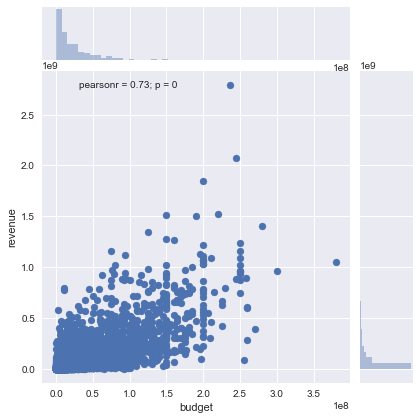

In [318]:
sns.jointplot(x='budget',y='revenue',data=df[df['return'].notnull()])

In [319]:
df['revenue'].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

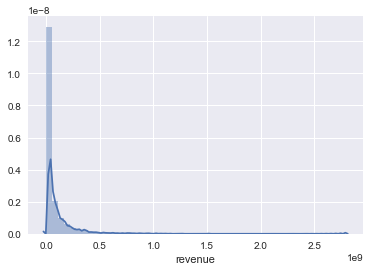

In [322]:
sns.distplot(df[df['revenue'].notnull()]['revenue'])

### Highest Grossing Films of All Time

In [327]:
gross_top = df[['poster_path','title','budget','revenue','year']].sort_values('revenue',ascending=False).head(10)

In [328]:
pd.set_option('display.max_colwidth',100)
HTML(gross_top.to_html(escape=False))

,poster_path,title,budget,revenue,year
14551,,Avatar,237000000.0,2.787965e+09,2009
26555,,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
1639,,Titanic,200000000.0,1.845034e+09,1997
17818,,The Avengers,220000000.0,1.519558e+09,2012
25084,,Jurassic World,150000000.0,1.513529e+09,2015
28830,,Furious 7,190000000.0,1.506249e+09,2015
26558,,Avengers: Age of Ultron,280000000.0,1.405404e+09,2015
17437,,Harry Potter and the Deathly Hallows: Part 2,125000000.0,1.342000e+09,2011
22110,,Frozen,150000000.0,1.274219e+09,2013
42222,,Beauty and the Beast,160000000.0,1.262886e+09,2017


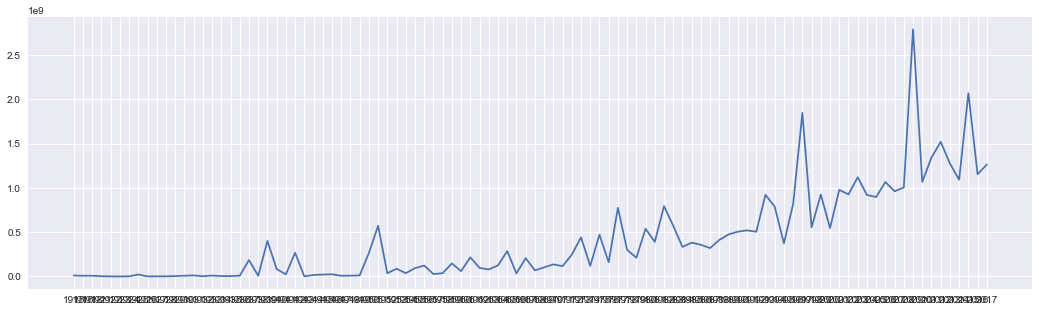

In [332]:
plt.figure(figsize=(18,5))
year_revenue = df[(df['revenue'].notnull()) & (df['year'] != 'NaT')].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.show()

In [333]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(10)

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
256,Star Wars,11000000.0,775398007.0,70.490728,1977
1338,Jaws,7000000.0,470654000.0,67.236286,1975
1888,The Exorcist,8000000.0,441306145.0,55.163268,1973
352,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994
834,The Godfather,6000000.0,245066411.0,40.844402,1972
4492,Look Who's Talking,7500000.0,296000000.0,39.466667,1989
24258,Annabelle,6500000.0,255273813.0,39.272894,2014
1056,Dirty Dancing,6000000.0,213954274.0,35.659046,1987
1006,The Sound of Music,8200000.0,286214286.0,34.904181,1965


In [334]:
df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return').head(10)

,title,budget,revenue,return,year
11159,Chaos,20000000.0,10289.0,0.000514,2005
19027,5 Days of War,20000000.0,17479.0,0.000874,2011
21034,Special Forces,10000000.0,10759.0,0.001076,2011
25732,Foodfight!,65000000.0,73706.0,0.001134,2012
38388,Term Life,16500000.0,21256.0,0.001288,2016
19505,Laurence Anyways,9500000.0,12250.0,0.001289,2012
12038,The Good Night,15000000.0,20380.0,0.001359,2007
3966,Cherry 2000,10000000.0,14000.0,0.001400,1987
22097,Twice Born,13000000.0,18295.0,0.001407,2012
5651,All The Queen's Men,15000000.0,23000.0,0.001533,2001


In [336]:
df['year'] = df['year'].replace('NaT', np.nan)

In [337]:
df['year'] = df['year'].apply(clean_numeric)

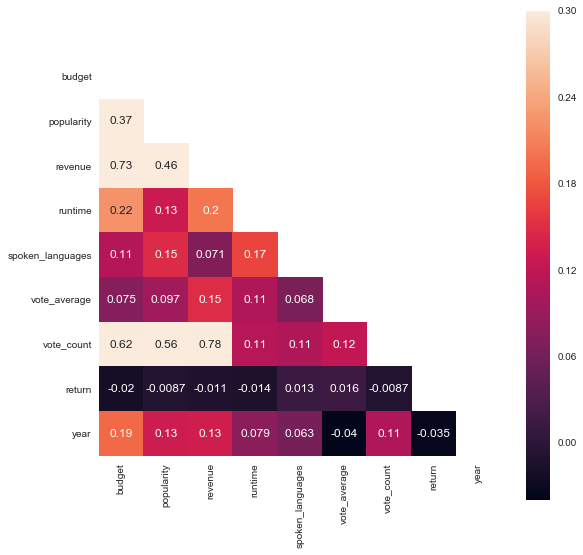

In [338]:
sns.set(font_scale=1)
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

### Genres

In [339]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [340]:
display(df['genres'].sample(20))

13932               [Thriller, Crime, Drama]
20645                       [Drama, Romance]
7110                        [Drama, History]
13892               [Comedy, Drama, Romance]
7731                        [Drama, Mystery]
39068                      [Comedy, Foreign]
8015                                [Comedy]
12190    [Comedy, Science Fiction, Thriller]
30884        [Comedy, Documentary, TV Movie]
43126                    [Action, Adventure]
5517                               [Western]
4541      [Drama, Horror, Mystery, Thriller]
24569                               [Family]
37892                               [Comedy]
35272             [Crime, Mystery, Thriller]
36338                             [Thriller]
42364                          [Documentary]
31952         [Animation, Adventure, Comedy]
38175                                     []
20607                                [Drama]
Name: genres, dtype: object

In [341]:
s = df['genres'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1,drop=True)
s.name = 'genre'

In [342]:
s.head(10)

0    Animation
0       Comedy
0       Family
1    Adventure
1      Fantasy
1       Family
2      Romance
2       Comedy
3       Comedy
3        Drama
Name: genre, dtype: object

In [343]:
gen_df = df.drop('genres',axis=1).join(s)

In [344]:
gen_df['genre'].value_counts().shape

(32,)

In [345]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre','movies']
pop_gen.head(10)

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


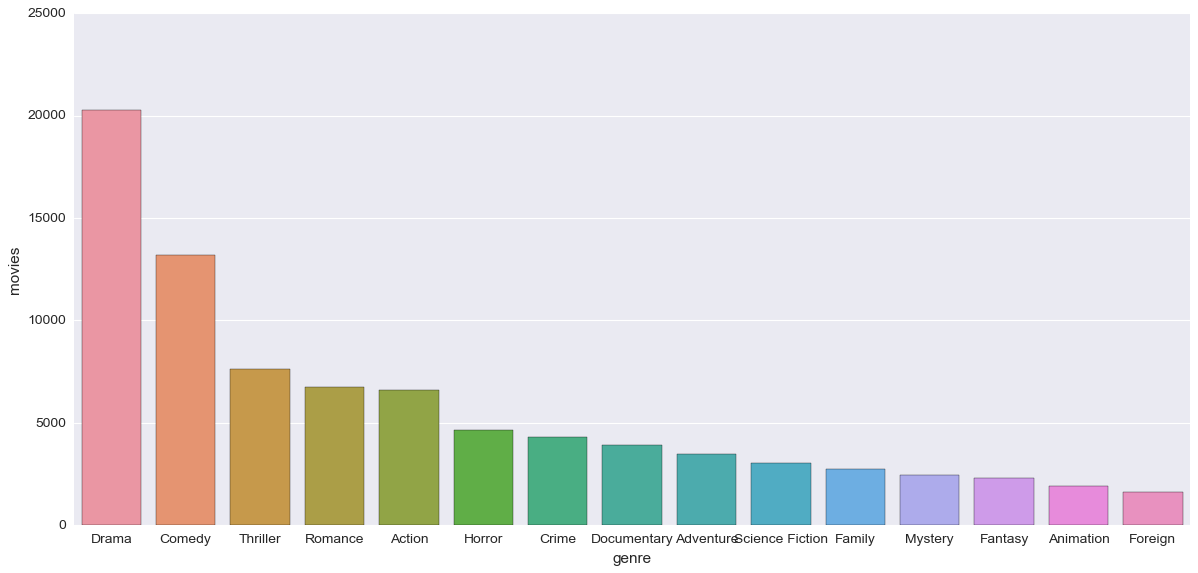

In [351]:
plt.figure(figsize=(18,8))
sns.barplot(data=pop_gen.head(15),x='genre',y='movies')
plt.show()

In [352]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

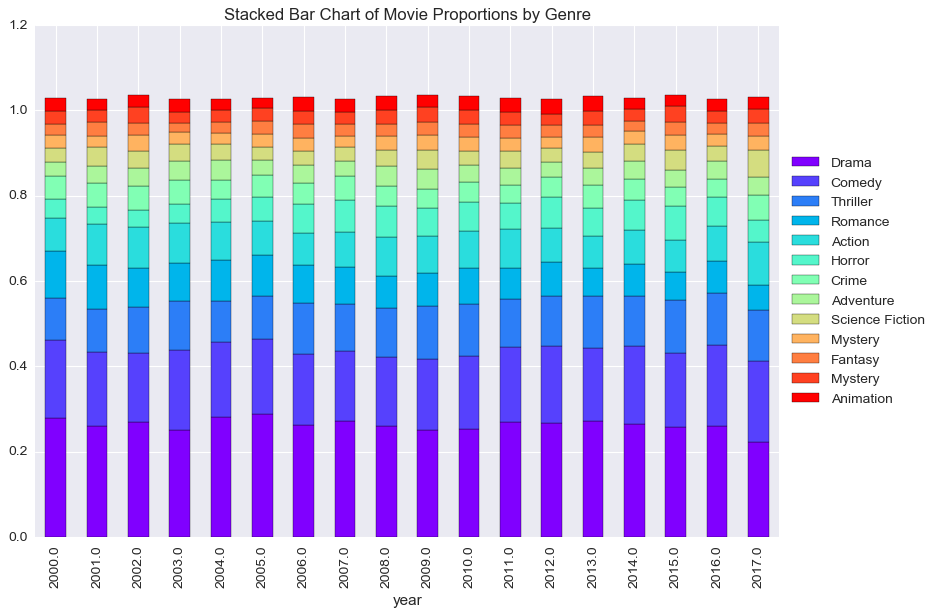

In [355]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres)) & (gen_df['year'] >= 2000) & (gen_df['year'] <= 2017)]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap=plt.cm.rainbow, figsize=(12,8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

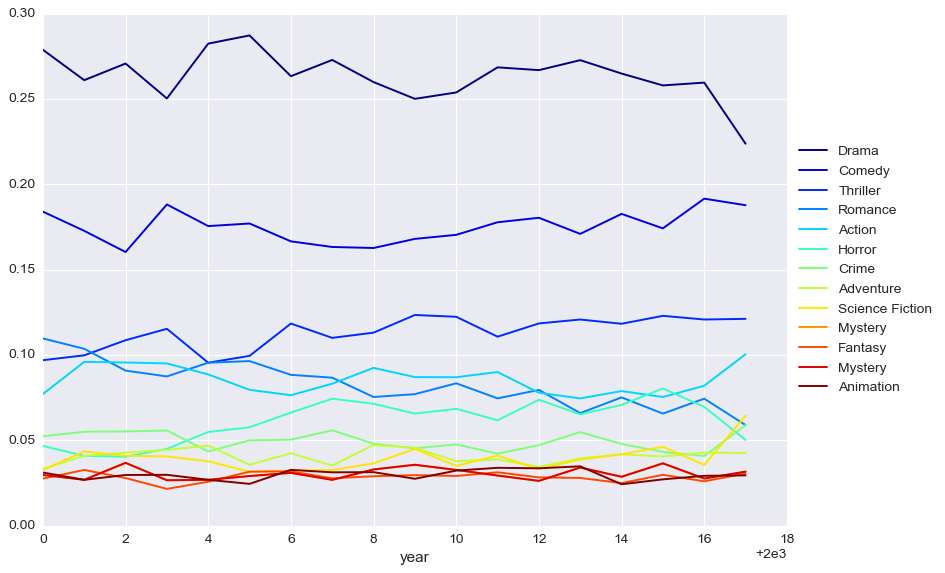

In [359]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [374]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

<Figure size 1440x640 with 0 Axes>

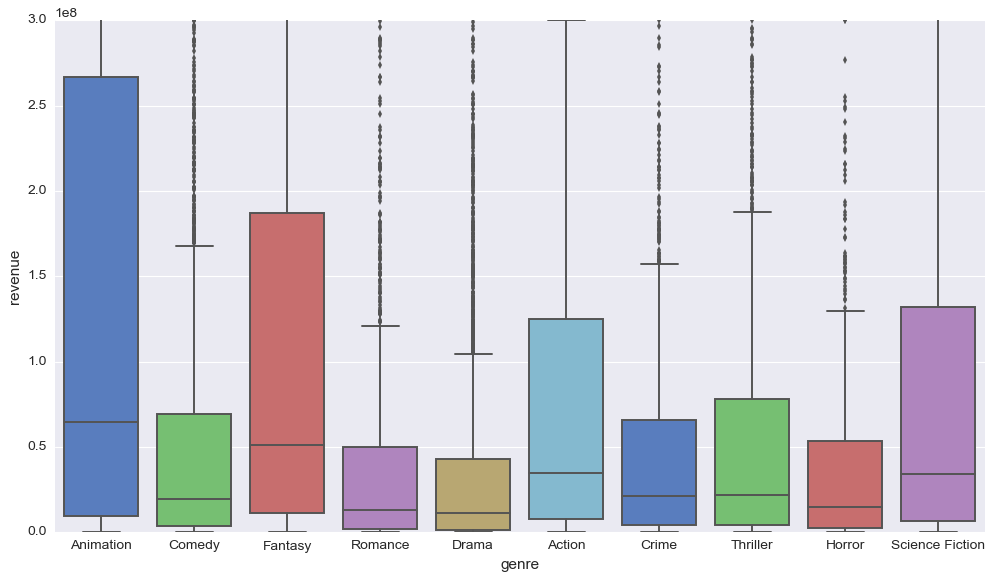

In [375]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='revenue', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 3e8])
plt.show()

<Figure size 1440x640 with 0 Axes>

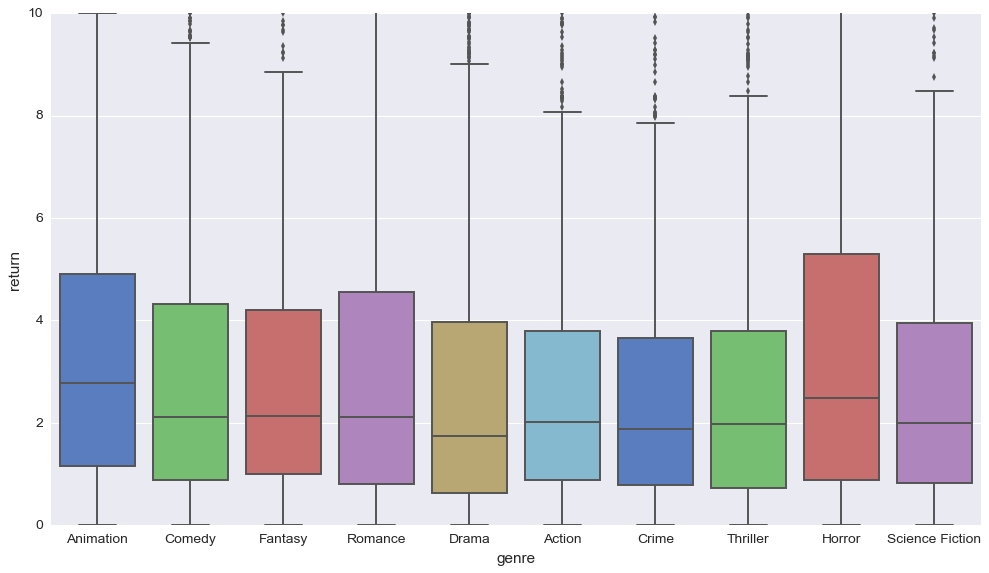

In [376]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.show()

### Cast and Crew

In [377]:
credits_df = pd.read_csv('the-movies-dataset/credits.csv')

In [378]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


#### Credits Dataset

- cast: 演员表和相关角色
- crew: 全体剧组和相关工作角色
- id: 电影在TMDB的Id

In [ ]:
def conver_int(x):
    